In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

import emcee
import george
from george import kernels
import corner

import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
ncores = 2
np.random.seed(23)

In [5]:
def gen_periodic_data(x, period, amplitude, offset, noise):
    
    y = offset + amplitude*np.cos(2*np.pi*x/period) + np.random.normal(0, np.sqrt(noise), size=len(x))
    return y

In [23]:
def plot_chains(sampler, nburn, paramsNames):
    Nparams = len(paramsNames)  # + 1
    fig, ax = plt.subplots(Nparams,1, figsize = (8,2*Nparams), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = range(len(sampler.chain[0,:,0]))

    for i,p in enumerate(paramsNames):
        for w in range(sampler.chain.shape[0]):
            ax[i].plot(xplot[:nburn], sampler.chain[w,:nburn,i], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.chain[w,nburn:,i], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
#     ax[-1].plot(xplot[:nburn], sampler.lnprobability.T[:nburn], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
#     ax[-1].plot(xplot[nburn:], sampler.lnprobability.T[nburn:], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
    fig.tight_layout()
    return ax

<IPython.core.display.Javascript object>


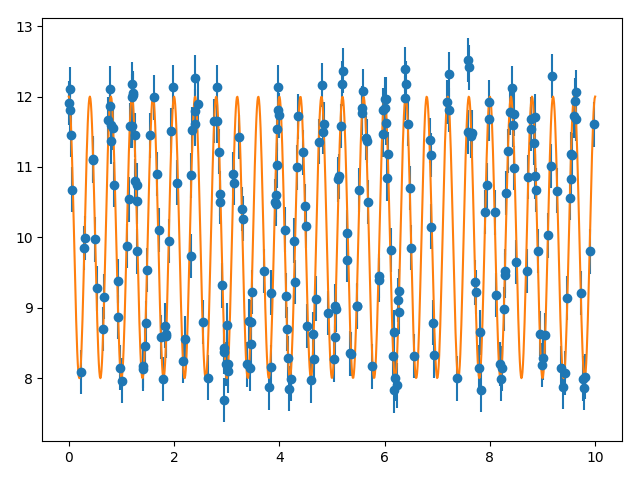

In [7]:
x = np.random.rand(250)*10
y = gen_periodic_data(x, 0.4, 2, 10, 0.1)
dy = np.ones_like(x)*np.sqrt(0.1)

x_grid = np.linspace(0,10,1000)

fig, ax = plt.subplots()
ax.errorbar(x, y, dy, fmt='o')
ax.plot(x_grid, 10 + 2*np.cos(2*np.pi*x_grid/0.4))
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.tight_layout()

In [8]:
def correct_model(theta, t):
    a, b, c = theta
    return a + b*np.cos(2*np.pi*t/c)

def lnlike1(theta, t, y, yerr):
    return -0.5 * np.sum(((y - correct_model(theta, t))/yerr) ** 2)

In [9]:
def nll(theta, t, y, yerr):
    return -1*lnlike1(theta, t, y, yerr)

res = minimize(nll, [10, 1, 0.39], args=(x, y, dy))

In [10]:
res

      fun: 2623.8326847469643
 hess_inv: array([[  1.89241651e-04,   1.40031534e-04,  -5.19957336e-05],
       [  1.40031534e-04,   6.55202086e-03,   1.22461152e-04],
       [ -5.19957336e-05,   1.22461152e-04,   4.05479230e-05]])
      jac: array([  0.00000000e+00,   6.10351562e-05,   0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 91
      nit: 14
     njev: 18
   status: 2
  success: False
        x: array([ 10.16174972,   0.16305949,   1.42809817])

<IPython.core.display.Javascript object>


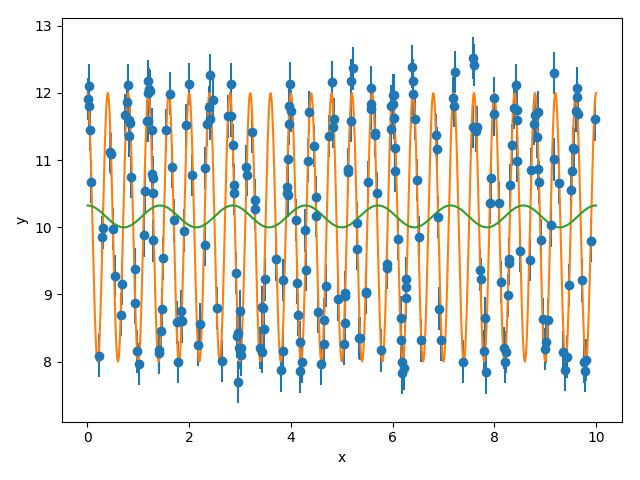

In [11]:
fig, ax = plt.subplots()
ax.errorbar(x, y, dy, fmt='o')
ax.plot(x_grid, 10 + 2*np.cos(2*np.pi*x_grid/0.4))
ax.plot(x_grid, correct_model(res['x'], x_grid))
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.tight_layout()

In [12]:
def lnprior1(theta):
    a, b, c = theta
    if (-20 < a < 20 and  -10 < b < 10 and -10 < c < 10):
        return 0.0
    return -np.inf

def lnprob1(theta, x, y, yerr):
    lp = lnprior1(theta)
    if np.isfinite(lp):
        return lp + lnlike1(theta, x, y, yerr)
    return -np.inf

In [13]:
guess = [10, 1, 0.6]
ndim = len(guess)
nwalkers = 100

p0 = [np.array(guess) + 1e-8 * np.random.randn(ndim)
      for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, args=(x, y, dy), threads = ncores)

In [14]:
sampler.run_mcmc(p0, 1000)

(array([[ 10.11117899,   0.36761954,   0.64447015],
        [ 10.18170234,   0.24760811,   0.538032  ],
        [ 10.14729196,   0.34107828,   0.64466039],
        [ 10.18615592,  -0.42022093,   0.51783515],
        [ 10.12545136,   0.39269847,   0.64526836],
        [ 10.22318359,   0.3099161 ,   0.53820561],
        [ 10.20367158,   0.34963138,   0.53795397],
        [ 10.16067577,   0.30893511,   0.64615345],
        [ 10.15152312,   0.36025189,   0.64521613],
        [ 10.16710925,   0.30840892,   0.53864582],
        [ 10.15238406,   0.36996858,   0.64562938],
        [ 10.0867662 ,   0.39787964,   0.6456148 ],
        [ 10.12522106,   0.30871108,   0.64563517],
        [ 10.11612451,   0.34852709,   0.64426674],
        [ 10.10915688,   0.37844154,   0.64514368],
        [ 10.15906954,   0.39428207,   0.64452748],
        [ 10.16256864,   0.33743431,   0.64319863],
        [ 10.14874587,   0.40446421,   0.64308252],
        [ 10.22785972,  -0.52852761,   0.38888556],
        [ 10

<IPython.core.display.Javascript object>


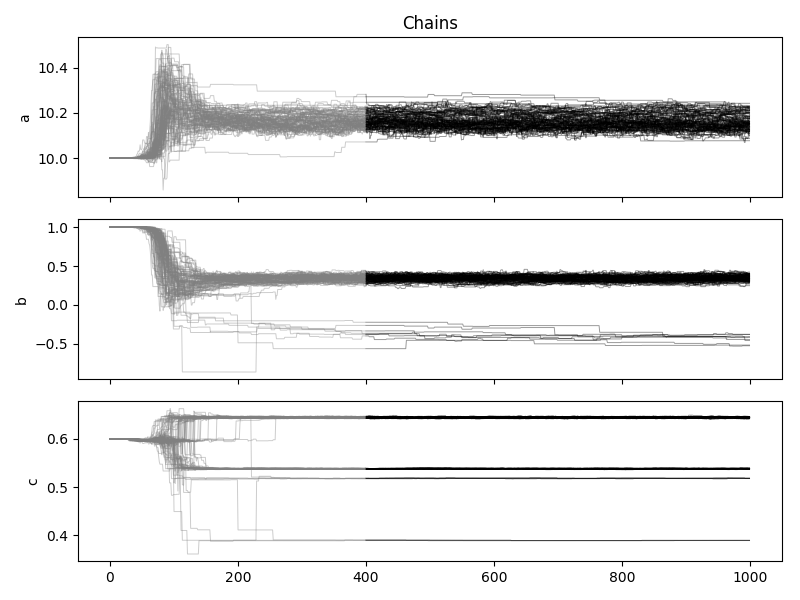

array([<matplotlib.axes._subplots.AxesSubplot object at 0x116b8bb70>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x118a4bfd0>], dtype=object)

In [24]:
params_names = ['a', 'b', 'c']
nburn = 400
plot_chains(sampler, nburn, params_names)

In [25]:
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

<IPython.core.display.Javascript object>


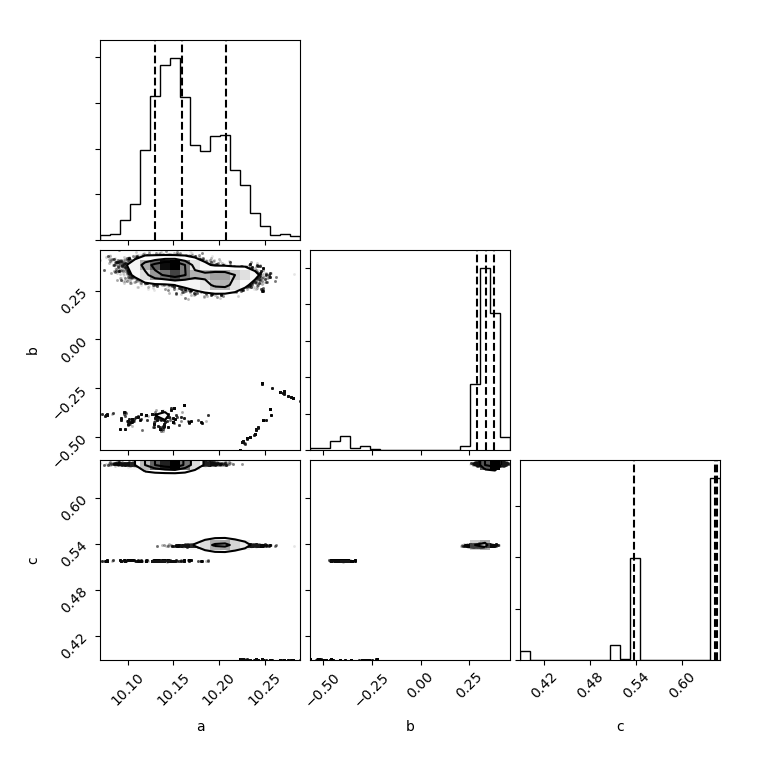

In [28]:
fig = corner.corner(samples, labels = ['a', 'b', 'c'], quantiles=[0.16,0.50,0.84])

In [29]:
def model2(theta, t):
    _, _, b = theta
    return b

def lnlike2(theta, t, y, yerr):
    lnper, lna = theta[:2]
    gp = george.GP(np.exp(lna) * kernels.CosineKernel(lnper))
    gp.compute(t, yerr)
    return gp.lnlikelihood(y - model2(theta, t), quiet=True)

def lnprior2(theta):
    lnper, lna, b = theta
    if (-20 < lna < 20 and 
        -20 < b < 20 and 
        -10 < lnper < np.log(10)):
        return 0.0
    return -np.inf

def lnprob2(p, x, y, yerr):
    lp = lnprior2(p)
    return lp + lnlike2(p, x, y, yerr) if np.isfinite(lp) else -np.inf

In [30]:
initial = np.array([1, 1, 8])
ndim = len(initial)
p0 = [np.array(initial) + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(x,y,dy), threads = ncores)


In [31]:
p0, _, _ = sampler.run_mcmc(p0, 200)

<IPython.core.display.Javascript object>


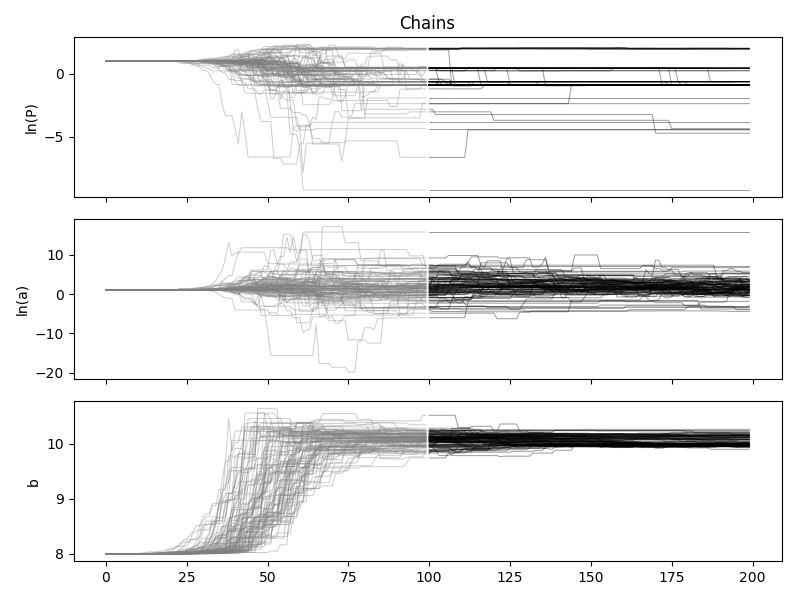

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1218ccf60>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x121915978>], dtype=object)

In [32]:
params_names = ['ln(P)', 'ln(a)', 'b']
nburn=100
plot_chains(sampler, nburn, params_names)

<IPython.core.display.Javascript object>


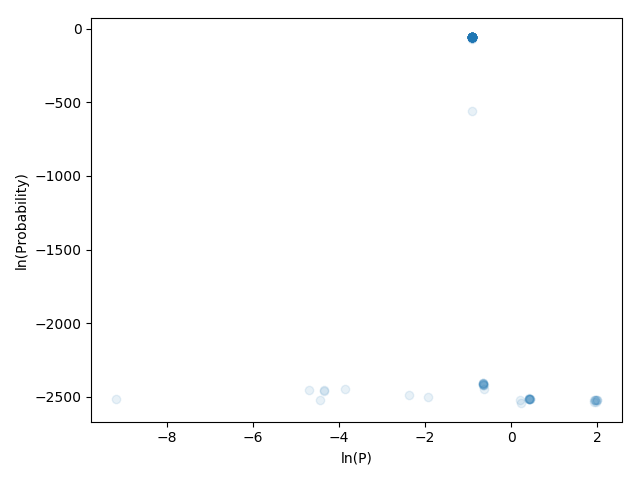

In [34]:
chain_lnp_end = sampler.chain[:,-1,0]
chain_lnprob_end = sampler.lnprobability[:,-1]
fig, ax = plt.subplots()
ax.scatter(chain_lnp_end, chain_lnprob_end, alpha=0.1)
ax.set_xlabel('ln(P)')
ax.set_ylabel('ln(Probability)')
fig.tight_layout()

In [35]:
p = p0[np.argmax(sampler.lnprobability[:,-1])]
sampler.reset()

In [36]:
p0 = [p + 1e-8 * np.random.randn(ndim) for i in range(nwalkers)]
p0, _, _ = sampler.run_mcmc(p0, 200)

<IPython.core.display.Javascript object>


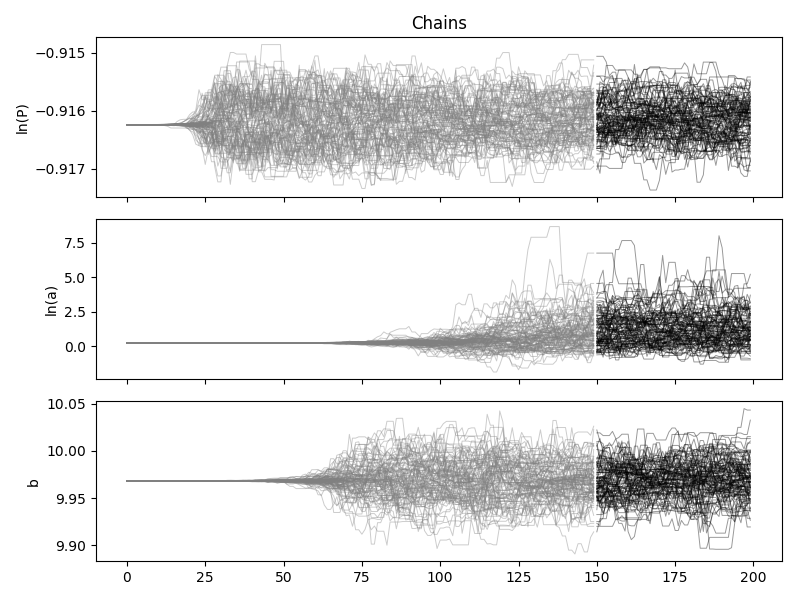

array([<matplotlib.axes._subplots.AxesSubplot object at 0x127fca0b8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x127fd0c18>], dtype=object)

In [38]:
paramsNames = ['ln(P)', 'ln(a)', 'b']
nburn=150
plot_chains(sampler, nburn, paramsNames)

<IPython.core.display.Javascript object>


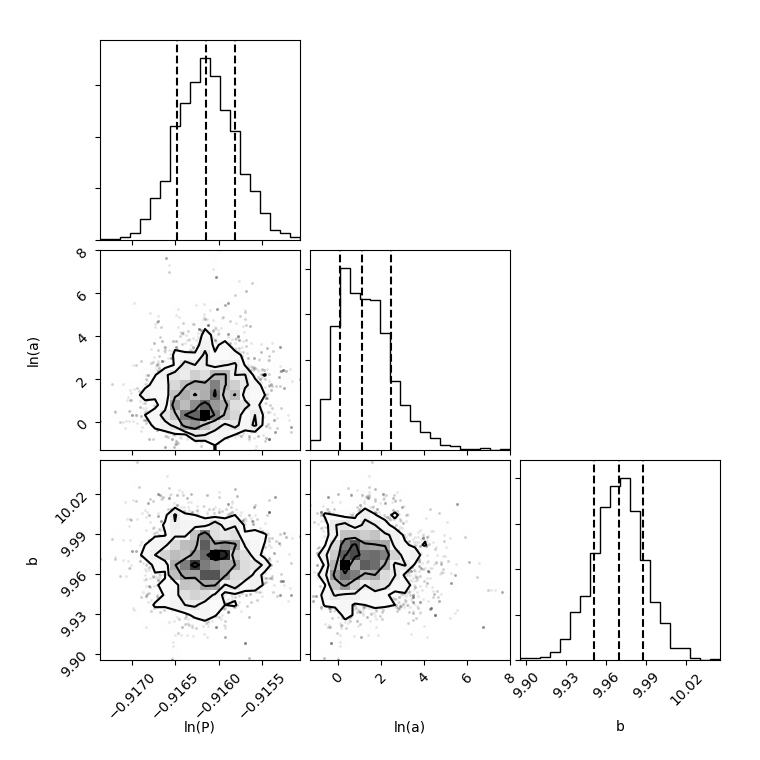

In [39]:
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=['ln(P)', 'ln(a)', 'b'], quantiles=[0.16,0.50,0.84])

<IPython.core.display.Javascript object>


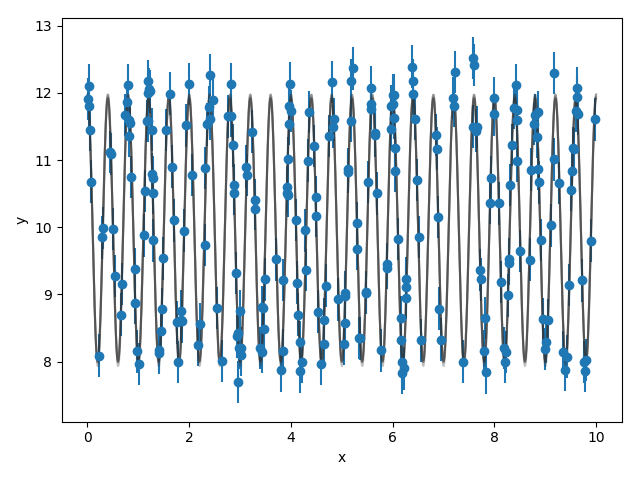

In [41]:
fig, ax = plt.subplots()
ax.errorbar(x, y, dy, fmt='o')
ax.set_xlabel('x')
ax.set_ylabel('y')

for s in samples[np.random.randint(len(samples), size=5)]:
    # Set up the GP for this sample.
    lnper, lna = s[:2]
    gp = george.GP(np.exp(lna) * kernels.CosineKernel(lnper))
    gp.compute(x, dy)
    # Compute the prediction conditioned on the observations and plot it.
    m = gp.sample_conditional(y - model2(s, x), x_grid) + model2(s, x_grid)
    
    ax.plot(x_grid, m, color="0.2", alpha=0.3)
fig.tight_layout()

In [42]:
p16, p50, p84 = np.percentile(samples[:,0], [16,50,84])

print('ln(P) = {:.6f} +{:.6f} -{:.6f}'.format(p50, p84-p50, p50-p16))

print('True period = 0.4, GP Period = {:.4f}'.format(np.exp(p50)))

ln(P) = -0.916146 +0.000341 -0.000337
True period = 0.4, GP Period = 0.4001


### Using the quasi-periodic kernel

In [43]:
def model3(theta, t):
    _, _, b, _ = theta
    return b

def lnlike3(theta, t, y, yerr):
    lnper, lna, b, lngamma = theta
    gp = george.GP(np.exp(lna) * kernels.ExpSine2Kernel(np.exp(lngamma), lnper))
    gp.compute(t, yerr)
    return gp.lnlikelihood(y - model3(theta, t), quiet=True)

def lnprior3(theta):
    lnper, lna, b, lngamma = theta
    if (-20 < lna < 20 and 
        -20 < b < 20 and 
        -20 < lngamma < 20 and
        -10 < lnper < np.log(10)):
        return 0.0
    return -np.inf

def lnprob3(p, x, y, yerr):
    lp = lnprior3(p)
    return lp + lnlike3(p, x, y, yerr) if np.isfinite(lp) else -np.inf

In [44]:
initial = np.array([0, 1, 10, 1])
ndim = len(initial)
p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
      for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob3, args=(x,y,dy), threads = ncores)

In [45]:
p0, _, _ = sampler.run_mcmc(p0, 200)

<IPython.core.display.Javascript object>


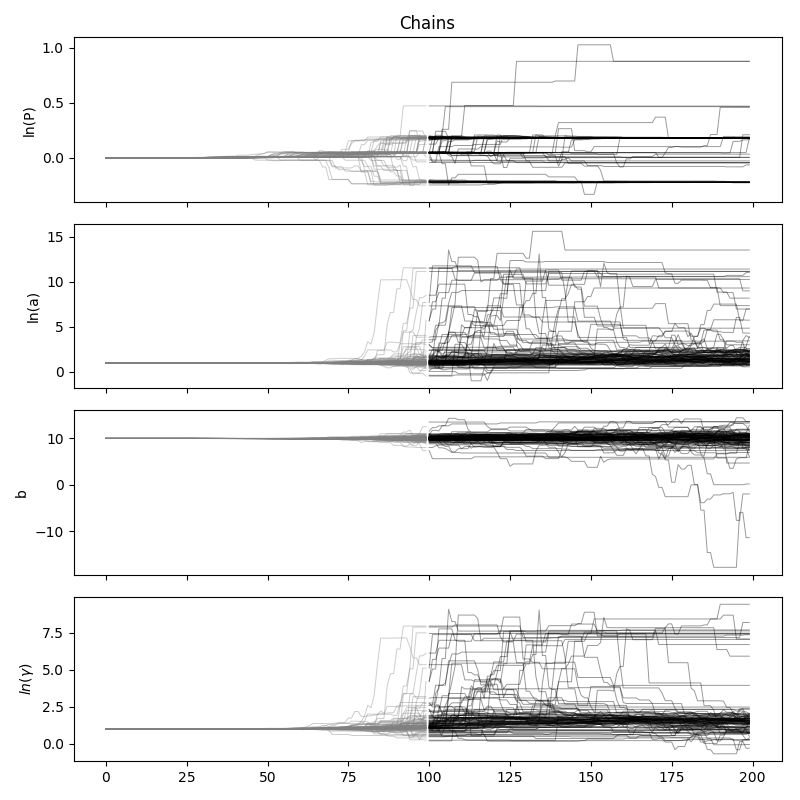

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1292e5f98>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x12f8b3390>], dtype=object)

In [46]:
paramsNames = ['ln(P)', 'ln(a)', 'b', '$ln(\gamma)$']
nburn = 100
plot_chains(sampler, nburn, paramsNames)

<IPython.core.display.Javascript object>


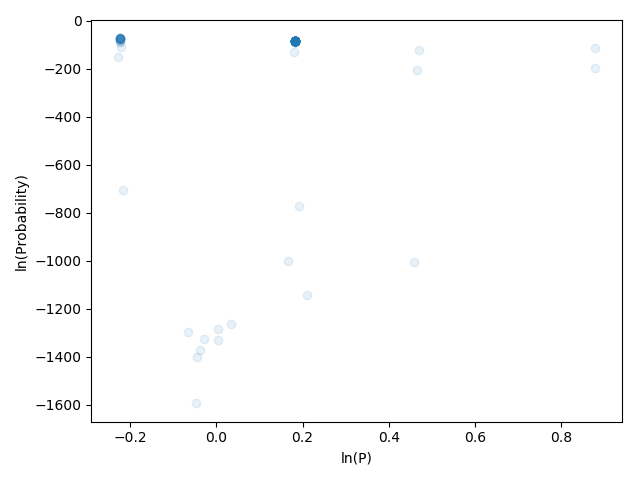

In [48]:
chain_lnp_end = sampler.chain[:,-1,0]
chain_lnprob_end = sampler.lnprobability[:,-1]
fig, ax = plt.subplots()
ax.scatter(chain_lnp_end, chain_lnprob_end, alpha=0.1)
ax.set_xlabel('ln(P)')
ax.set_ylabel('ln(Probability)')
fig.tight_layout()

In [49]:
p = p0[np.argmax(chain_lnprob_end)]
sampler.reset()

In [50]:
p0 = [p + 1e-8 * np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(p0, 500)

(array([[ -2.22591538e-01,   4.36319047e+00,  -4.79704767e+00,
          -1.16920243e+00],
        [ -2.23110093e-01,   1.88377900e+00,   1.15100871e+01,
           3.73758450e-01],
        [ -2.22561150e-01,   3.93920323e+00,   2.41557497e+00,
          -7.88385369e-01],
        [ -2.23187961e-01,   4.28160499e+00,   1.09859177e+01,
          -9.18032569e-01],
        [ -2.23100474e-01,   4.16720433e+00,   1.35744067e+01,
          -1.55262838e-01],
        [ -2.23188544e-01,   6.64640325e+00,  -1.58492910e+01,
          -2.19519102e+00],
        [ -2.23754324e-01,   4.90807541e+00,  -1.22415437e+01,
          -8.96378121e-01],
        [ -2.23243393e-01,   4.68100587e+00,   1.41513872e+01,
          -7.22560260e-01],
        [ -2.22775919e-01,   6.37707025e+00,   9.53114859e+00,
          -2.03055357e+00],
        [ -2.23056963e-01,   1.88546270e+00,   1.05336340e+01,
           3.76634275e-01],
        [ -2.23110432e-01,   1.58369796e+00,   8.73960468e+00,
           4.83634895e-01],

<IPython.core.display.Javascript object>


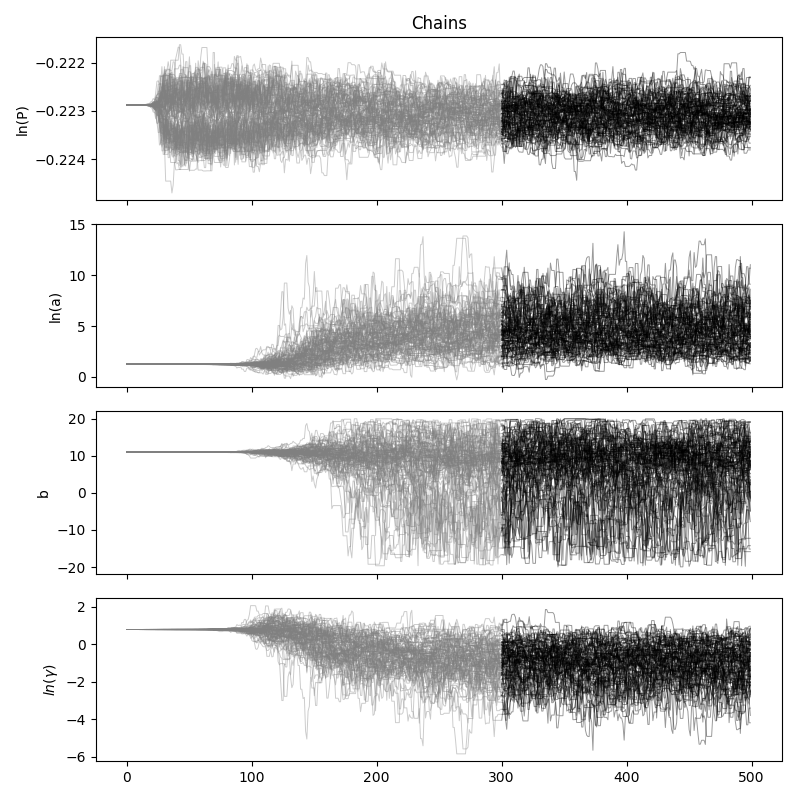

array([<matplotlib.axes._subplots.AxesSubplot object at 0x128cca5c0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x128f04780>], dtype=object)

In [53]:
paramsNames = ['ln(P)', 'ln(a)', 'b', '$ln(\gamma)$']
nburn = 300
plot_chains(sampler, nburn, paramsNames)

<IPython.core.display.Javascript object>


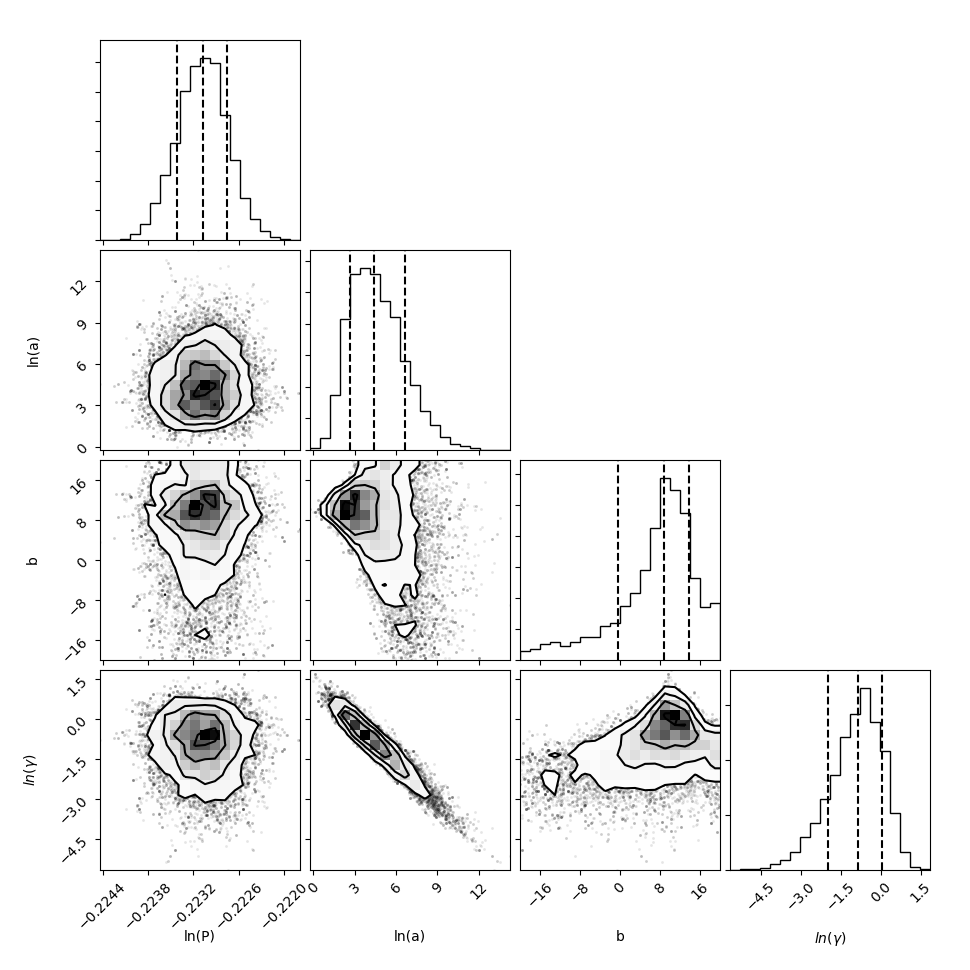

In [54]:
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=paramsNames, quantiles=[0.16,0.50,0.84])

### Applying the model to real world data

In [55]:
lc = pd.read_csv("lc8.dat")

def lnprior3(theta):
    lnper, lna, b, lngamma = theta
    if (-20 < lna < 20 and 
        0 < b < 20 and 
        -20 < lngamma < 20 and
        -10 < lnper < np.log(np.ptp(lc['hjd']))):
        return 0.0
    return -np.inf

In [87]:
from astropy.stats import LombScargle

frequency, power = LombScargle(lc['hjd'], lc['mag'], lc['mag_unc'], nterms=2).autopower(maximum_frequency=5)

print('Top LS period is {}'.format(1/frequency[np.argmax(power)]))

Top LS period is 0.7350856847545221


In [89]:
np.argmax(power)
1/frequency[np.argsort(power)[::-1][0:5]]

array([ 0.73508568,  0.36753832,  0.36754736,  0.2117088 ,  0.2117058 ])

In [111]:
initial1 = np.array([np.log(0.735), 1, 10, 1])
ndim = len(initial1)
nwalkers = 34
p1 = [np.array(initial1) + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

initial2 = np.array([np.log(0.367), 1, 10, 1])
ndim = len(initial2)
nwalkers = 33
p2 = [np.array(initial2) + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

initial3 = np.array([np.log(0.211), 1, 10, 1])
ndim = len(initial3)
nwalkers = 33
p3 = [np.array(initial3) + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]
p0 = p1+p2+p3

nwalkers = len(p0)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob3, args=(lc['hjd'],lc['mag'],lc['mag_unc']), threads = ncores)

In [112]:
p0, _, _ = sampler.run_mcmc(p0, 500)

<IPython.core.display.Javascript object>


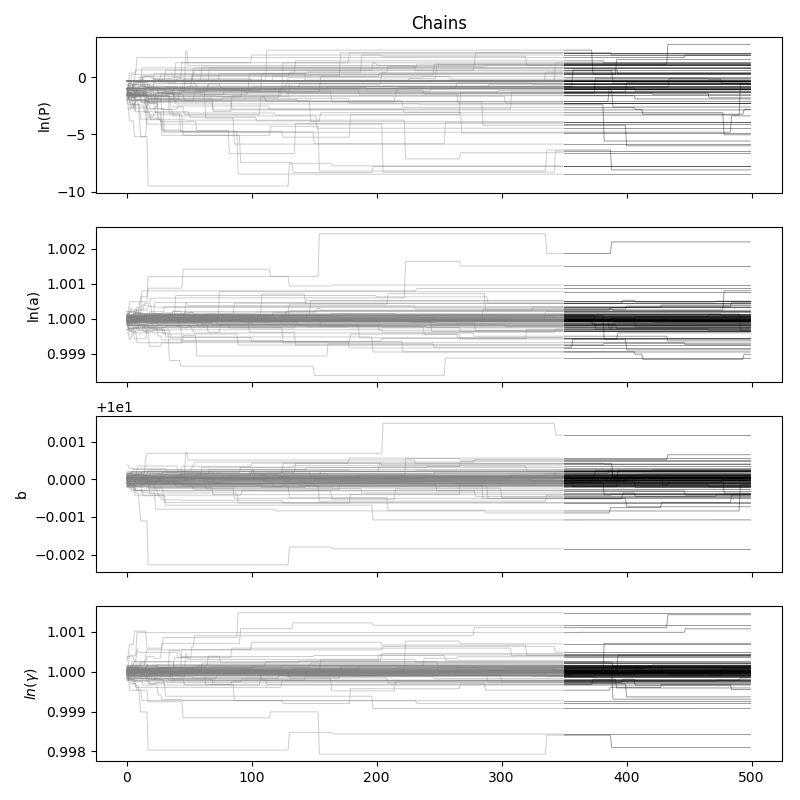

array([<matplotlib.axes._subplots.AxesSubplot object at 0x139c030b8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x13903cc18>], dtype=object)

In [113]:
paramsNames = ['ln(P)', 'ln(a)', 'b', '$ln(\gamma)$']
nburn = 350
plot_chains(sampler, nburn, paramsNames)

<IPython.core.display.Javascript object>


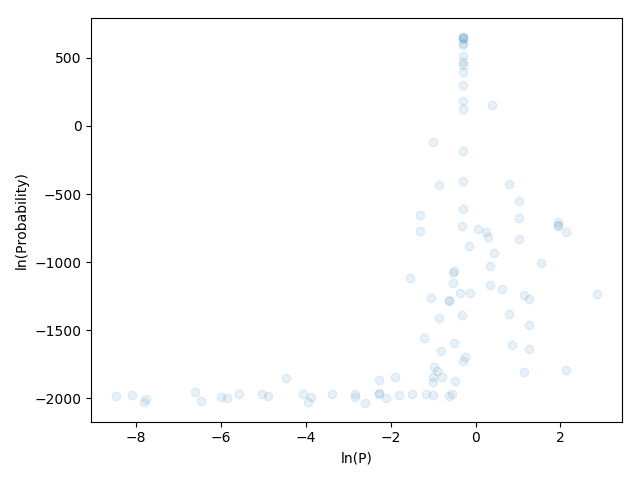

In [114]:
chain_lnp_end = sampler.chain[:,-1,0]
chain_lnprob_end = sampler.lnprobability[:,-1]
fig, ax = plt.subplots()
ax.scatter(chain_lnp_end, chain_lnprob_end, alpha=0.1)
ax.set_xlabel('ln(P)')
ax.set_ylabel('ln(Probability)')
fig.tight_layout()

In [115]:
p = p0[np.argmax(chain_lnprob_end)]
sampler.reset()

In [117]:
p0 = [p + 1e-8 * np.random.randn(ndim) for i in range(nwalkers)]
sampler.reset()
sampler.run_mcmc(p0, 500)

(array([[ -0.30777009,  -4.05801238,  11.02751991,   2.08547055],
        [ -0.30776969,  -4.00731375,  10.90034974,   2.13771131],
        [ -0.30776909,  -4.46689148,  10.84471694,   2.37556611],
        [ -0.3077685 ,  -4.28355552,  10.9338625 ,   2.20144642],
        [ -0.30776885,  -4.87732549,  10.97271074,   2.32256785],
        [ -0.30777043,  -4.43405954,  10.99519544,   2.45863393],
        [ -0.30777011,  -4.62800167,  10.94185828,   2.64232475],
        [ -0.30777026,  -3.92034706,  10.89733367,   2.00733676],
        [ -0.30776893,  -4.10248453,  10.91022038,   2.10020651],
        [ -0.30776834,  -4.5245611 ,  10.95550378,   2.70352421],
        [ -0.3077692 ,  -4.43359983,  10.99138666,   2.03119181],
        [ -0.30777015,  -4.05393597,  10.90816882,   2.23487698],
        [ -0.30777112,  -2.69255882,  11.01452719,   1.88484181],
        [ -0.30776868,  -4.03436842,  10.95354027,   2.27907666],
        [ -0.30776966,  -4.87621758,  10.86969444,   2.41978314],
        [ 

<IPython.core.display.Javascript object>


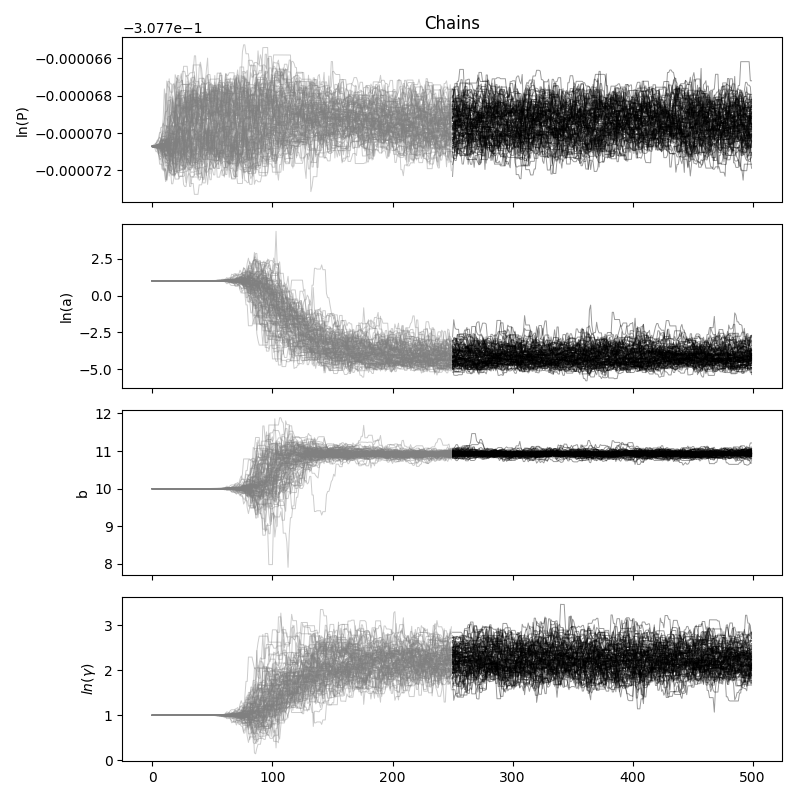

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13a422748>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x13b15d7b8>], dtype=object)

In [119]:
paramsNames = ['ln(P)', 'ln(a)', 'b', '$ln(\gamma)$']
nburn = 250
plot_chains(sampler, nburn, paramsNames)

<IPython.core.display.Javascript object>


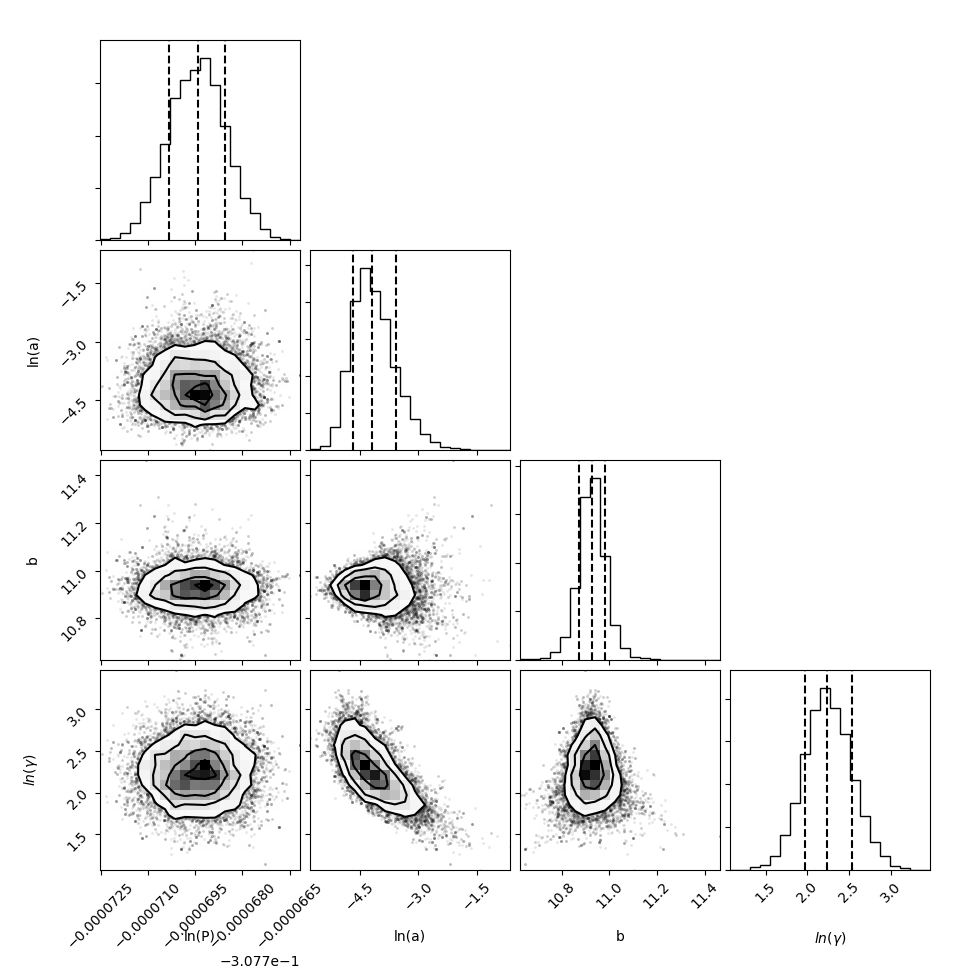

In [120]:
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=paramsNames, quantiles=[0.16,0.50,0.84])

In [121]:
p16, p50, p84 = np.percentile(samples[:,0], [16,50,84])

print('ln(P) = {:.6f} +{:.6f} -{:.6f}'.format(p50, p84-p50, p50-p16))

print('GP Period = {:.6f}'.format(np.exp(p50)))

ln(P) = -0.307769 +0.000001 -0.000001
GP Period = 0.735085


<IPython.core.display.Javascript object>


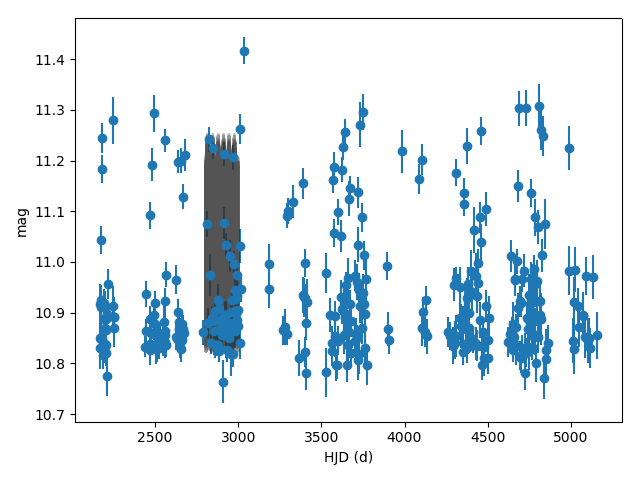

In [148]:
fig, ax = plt.subplots()
ax.errorbar(lc['hjd'], lc['mag'], lc['mag_unc'], fmt='o')
ax.set_xlabel('HJD (d)')
ax.set_ylabel('mag')

hjd_grid = np.linspace(2800, 3000,3000)

for s in samples[np.random.randint(len(samples), size=5)]:
    # Set up the GP for this sample.
    lnper, lna, b, lngamma = s
    gp = george.GP(np.exp(lna) * kernels.ExpSine2Kernel(np.exp(lngamma), lnper))
    gp.compute(lc['hjd'], lc['mag_unc'])
    # Compute the prediction conditioned on the observations and plot it.
    m = gp.sample_conditional(lc['mag'] - model3(s, lc['hjd']), hjd_grid) + model3(s, hjd_grid)
    
    ax.plot(hjd_grid, m, color="0.2", alpha=0.3)
fig.tight_layout()

In [143]:
lnper, lna, b, lngamma = s
gp = george.GP(np.exp(lna) * kernels.ExpSine2Kernel(np.exp(lngamma), lnper))
gp.compute(lc['hjd'], lc['mag_unc'])
hjd_grid = np.linspace(min(lc['hjd']), max(lc['hjd']),10000)
m = gp.sample_conditional(lc['mag'] - model3(s, lc['hjd']), hjd_grid) + model3(s, hjd_grid)

<IPython.core.display.Javascript object>


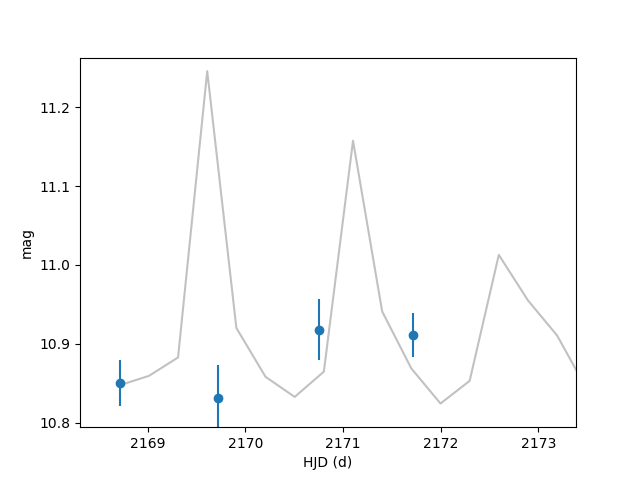

In [144]:
fig, ax = plt.subplots()
ax.errorbar(lc['hjd'], lc['mag'], lc['mag_unc'], fmt='o')
ax.set_xlabel('HJD (d)')
ax.set_ylabel('mag')
ax.plot(hjd_grid, m, color="0.2", alpha=0.3)

In [138]:
model3(s, hjd_grid)

10.944791303437038